In [1]:
using Pkg
using Plots, Random, Distributions
using BenchmarkTools

In [2]:
d = Cauchy(0,1)
u = truncated(d,-pi,pi)

Truncated(Cauchy{Float64}(μ=0.0, σ=1.0); lower=-3.141592653589793, upper=3.141592653589793)

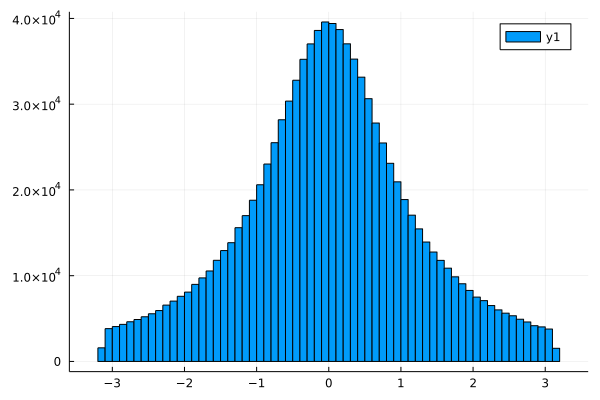

In [3]:
histogram(rand(u,1000000),bins= 100)

In [4]:
@benchmark rand(d,100000)

BenchmarkTools.Trial: 2077 samples with 1 evaluation.
 Range (min … max):  2.169 ms …   6.549 ms  ┊ GC (min … max): 0.00% … 63.42%
 Time  (median):     2.346 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.403 ms ± 380.328 μs  ┊ GC (mean ± σ):  2.02% ±  7.06%

  ▂  █▆▂                                                       
  █▇████▇▆▅▃▅▅▇▅▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▅▆ █
  2.17 ms      Histogram: log(frequency) by time      5.09 ms <

 Memory estimate: 781.30 KiB, allocs estimate: 2.

# ODE Test

In [2]:
using DifferentialEquations, LinearAlgebra, StaticArrays

In [8]:
N = 3200
Aij = ones((N,N)) - 1I;

gω = Cauchy(0,1)
g𝜽 = Uniform(-pi,pi) 
Kc = 2/(pi*pdf(gω,0))
theta = rand(g𝜽,N);
omega = rand(gω,N);
K = 3
tspan = (0,10)

(0, 10)

In [9]:
typeof(omega)

Vector{Float64} (alias for Array{Float64, 1})

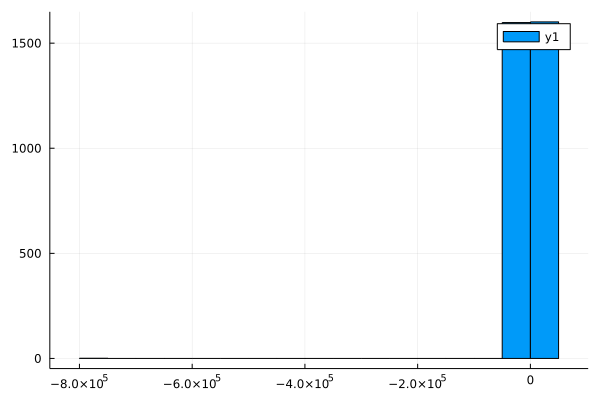

In [10]:
histogram(omega,bins=20)

In [5]:
function kuramoto(u,t)
    i,j = u,u'
    inter = @.sin(j-i)*Aij
    return theta = vec(omega + K*sum(inter,dims=2)/N)
end
function kuramoto_mean(u,t)
    rpsi = (1/N)*sum(exp.(u*1im))
    r = abs(rpsi)
    psi = angle(rpsi)
    dxdu = vec(omega + K*r*sin.(-(u.-psi)))
    return dxdu
end
function kuramoto_mean(u,p,t)
    rpsi = (1/N)*sum(exp.(u*1im))
    dxdu = vec(omega + K*abs(rpsi)*sin.(-(u.-angle(rpsi))))
    return dxdu
end
function kuramoto(u,p,t)
    i,j = u,u'
    inter = @.sin(j-i)*Aij
    return theta = vec(omega + K*sum(inter,dims=2)/N)
end

kuramoto (generic function with 2 methods)

In [6]:
function rungekutta4(f, y0, t)
    n = length(t)
    y = zeros((n, length(y0)))
    y[1,:] = y0
    for i in 1:n-1
        h = t[i+1] - t[i]
        k1 = f(y[i,:], t[i])
        k2 = f(y[i,:] + k1 * h/2, t[i] + h/2)
        k3 = f(y[i,:] + k2 * h/2, t[i] + h/2)
        k4 = f(y[i,:] + k3 * h, t[i] + h)
        y[i+1,:] = y[i,:] + (h/6) * (k1 + 2*k2 + 2*k3 + k4)
    end
    return y
end

rungekutta4 (generic function with 1 method)

In [11]:
t = range(0,10,1001)

0.0:0.01:10.0

In [8]:
typeof(t)

StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}

In [ ]:
@benchmark begin
    sol = solve(prob,alg)
    sol(t) 
end

In [310]:
@benchmark 

BenchmarkTools.Trial: 585 samples with 1 evaluation.
 Range (min … max):  3.181 ms … 39.972 ms  ┊ GC (min … max):  0.00% … 83.67%
 Time  (median):     8.598 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   8.508 ms ±  6.029 ms  ┊ GC (mean ± σ):  14.09% ± 16.39%

  ▆       ▃█▅                                                 
  █▇█▅▆▆▄▇████▆▆▁▁▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▅▅▆▆▅ ▆
  3.18 ms      Histogram: log(frequency) by time     36.2 ms <

 Memory estimate: 15.50 MiB, allocs estimate: 32047.

In [12]:
@benchmark rungekutta4(kuramoto,theta,t)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 640.305 s (1.88% GC) to evaluate,
 with a memory estimate of 306.01 GiB, over 120492 allocations.

In [ ]:
@benchmark rungekutta4(kuramoto_mean,theta,t)

In [336]:
sol = rungekutta4(kuramoto_mean,theta,t);
# sol2 = rungekutta4(kuramoto,theta,t);

In [273]:
sol==sol2

false

In [335]:
plot(t,abs.(sum(exp.((sol(t).u)*1im)),dims=2))
# plot!(t,abs.(sum(exp.(sol2*1im),dims=2)))

LoadError: MethodError: no method matching exp(::Vector{ComplexF64})
[0mClosest candidates are:
[0m  exp([91m::Union{Float16, Float32, Float64}[39m) at C:\Users\kim9y\AppData\Local\Programs\Julia-1.7.3\share\julia\base\special\exp.jl:296
[0m  exp([91m::StridedMatrix{var"#s861"} where var"#s861"<:Union{Float32, Float64, ComplexF32, ComplexF64}[39m) at C:\Users\kim9y\AppData\Local\Programs\Julia-1.7.3\share\julia\stdlib\v1.7\LinearAlgebra\src\dense.jl:560
[0m  exp([91m::StridedMatrix{var"#s861"} where var"#s861"<:Union{Integer, Complex{<:Integer}}[39m) at C:\Users\kim9y\AppData\Local\Programs\Julia-1.7.3\share\julia\stdlib\v1.7\LinearAlgebra\src\dense.jl:561
[0m  ...

In [176]:
abs.(sum(exp.(sol*1im),dims=2))

1001×1 Matrix{Float64}:
 86.87712155540088
 86.55473747837432
 85.26243897326623
 81.98408964577865
 87.3985260985259
 85.95664443957888
 76.8912225024834
 84.56454362182033
 91.54016923707341
 89.05350816942843
 89.29843700302611
 90.38725317503284
 88.42317102239548
  ⋮
 26.77516061547822
 27.274967958003362
 29.466406991821387
 27.59862226523436
 21.430088388960158
 22.50742631190314
 26.39313277936049
 23.363829813911916
 25.45732211325474
 28.082768474393838
 30.39498263842058
 37.54839986523658